In [14]:
import os
import pickle

import torch
import torchvision
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats

from models import ARCNN


set_matplotlib_formats("retina")
mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "serif"

In [26]:
ORIGINAL_IMAGE = "data/100/test/16068.jpg"
TEST_IMAGE = "data/20/test/16068.jpg"
MODEL_PATH = "models/ARCNN-quality20-v0.1/ARCNN.pt"
# MODEL_PATH = "models/ARCNNv0.4/ARCNN.pt"

In [20]:
net = ARCNN()
net.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
net

ARCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=same)
  (conv2): Conv2d(64, 32, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (conv3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (conv4): Conv2d(16, 3, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (relu1): LeakyReLU(negative_slope=0.1)
  (relu2): LeakyReLU(negative_slope=0.1)
  (relu3): LeakyReLU(negative_slope=0.1)
)

In [21]:
def enhance(image):
    tofloat = torchvision.transforms.ConvertImageDtype(torch.float32)
    x = tofloat(image)
    with torch.no_grad():
        y = net(x)
    y = torch.clip(y, 0.0, 1.0)
    res = y.cpu()
    return res

In [22]:
tofloat = torchvision.transforms.ConvertImageDtype(torch.float32)

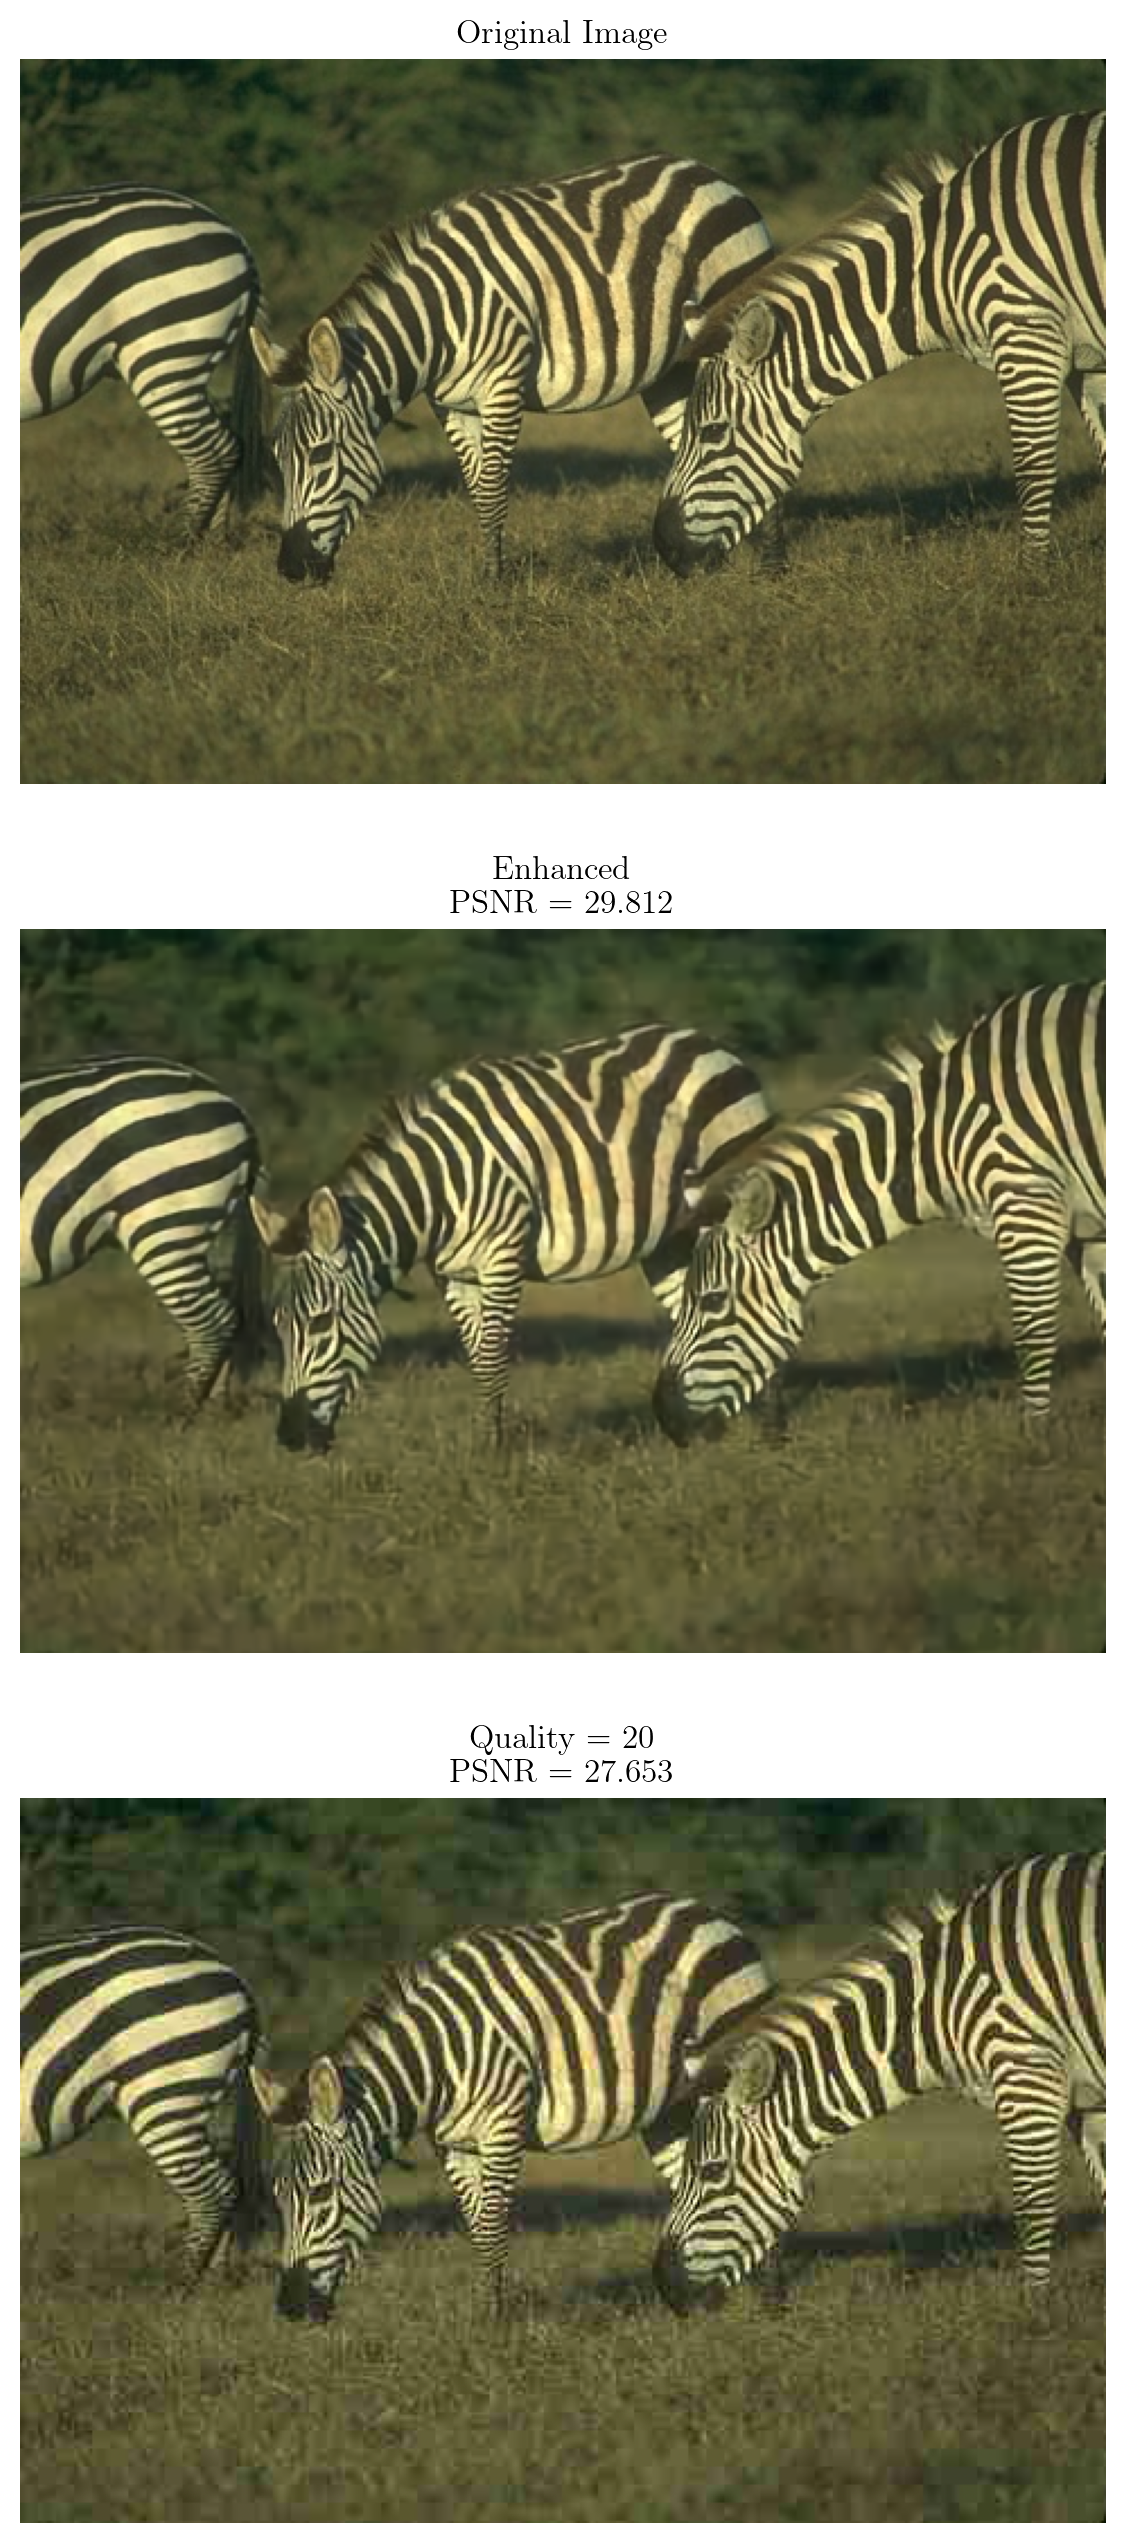

In [27]:
original = torchvision.io.read_image(ORIGINAL_IMAGE)
image = torchvision.io.read_image(TEST_IMAGE)
enhanced = enhance(image)

enhanced_mse = torch.mean((tofloat(original) - tofloat(enhanced)) ** 2).item()
enhanced_psnr = 10 * np.log10(1 / enhanced_mse)

baseline_mse = torch.mean((tofloat(image) - tofloat(original)) ** 2).item()
baseline_psnr = 10 * np.log10(1 / baseline_mse)

c, h, w = image.shape

fig, axs = plt.subplots(3, 1, figsize=(9, 16))
axs[0].imshow(original.permute(1,2,0).numpy())
axs[1].imshow(enhanced.permute(1,2,0).numpy())
axs[2].imshow(image.permute(1,2,0).numpy())

axs[0].set_title("Original Image")
axs[1].set_title(f"Enhanced\nPSNR = {enhanced_psnr:.3f}")
axs[2].set_title(f"Quality = 20\nPSNR = {baseline_psnr:.3f}")

for ax in axs:
    ax.set_axis_off()


Text(0.5, 1.0, 'PSNR during training')

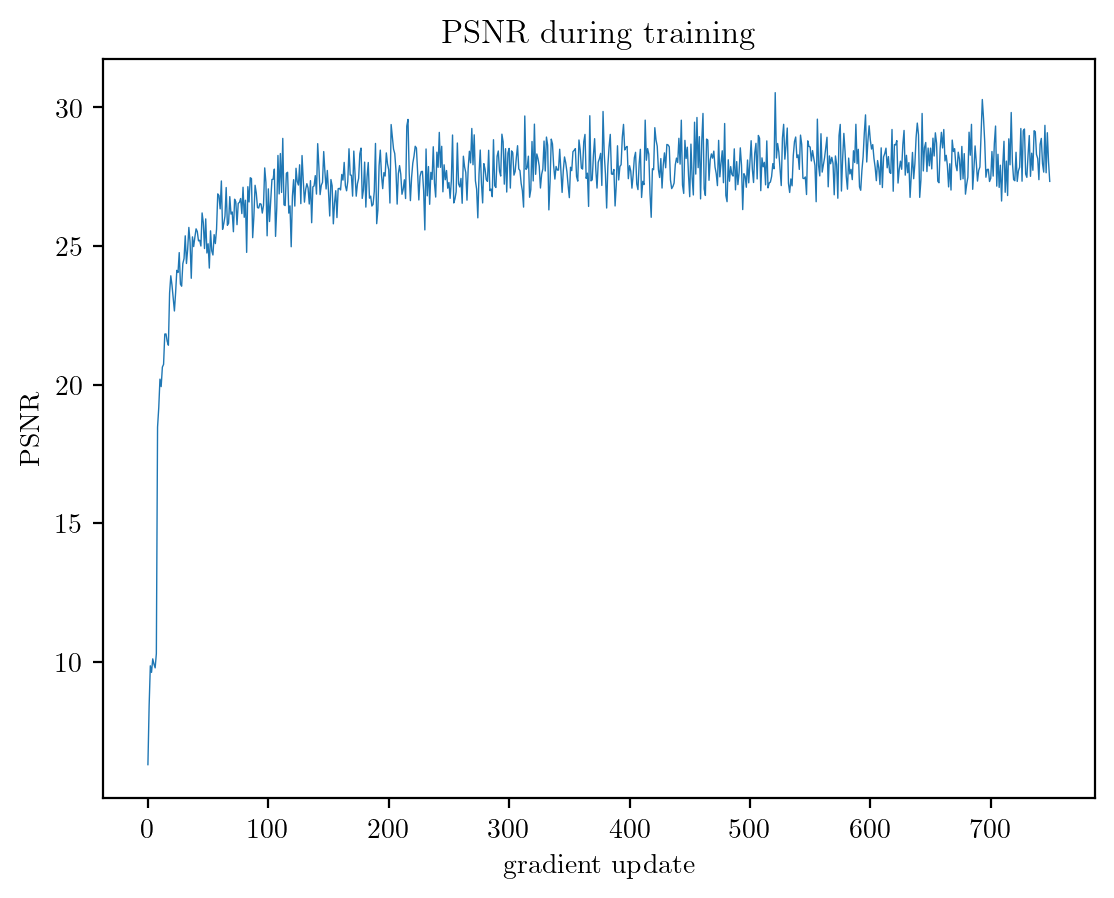

In [24]:
with open("models/history-v0.5.pickle", mode="rb") as f:
    history = pickle.load(f)
    mse = np.array(history)
    psnr = 10*np.log10(1/mse)

plt.plot(psnr, linewidth=0.5)
plt.yscale("linear")
plt.xlabel("gradient update")
plt.ylabel("PSNR")
plt.title("PSNR during training")
